## PLOT NIO

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25552\579693572.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25552\579693572.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 0.0369 - val_loss: 1.2585e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0025 - val_loss: 1.0147e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0016 - val_loss: 7.9859e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0011 - val_loss: 6.9807e-05
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 8.3898e-04 - val_loss: 5.4606e-05
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.4722e-04 - val_loss: 7.5836e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.6538e-04 - val_loss: 4.0775e-05
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 8.5044e-04 - val_loss: 1.5382e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.3882e-04 - val_loss: 7.8920e-05
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 4.5704e-05
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 7.5689e-04 - val_l

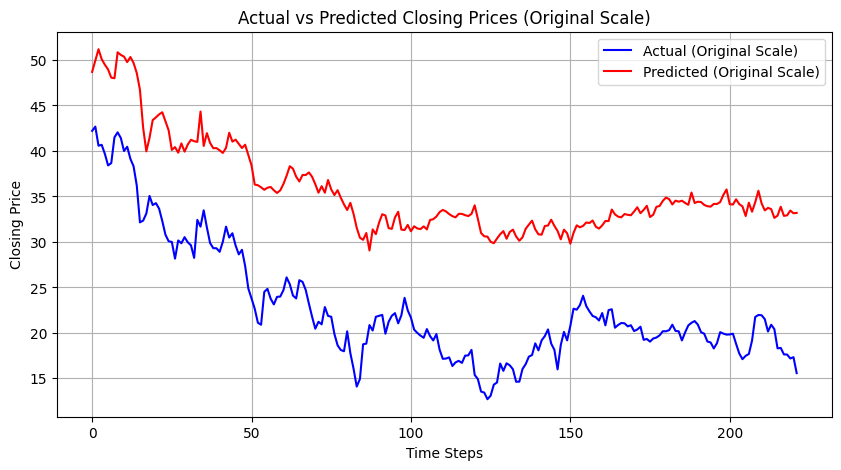

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
companies = data['Stock Name'].unique()
data = data.sort_values(by=['Stock Name', 'Date'])

#data.drop(columns=['Stock Name'], inplace=True)
# data.drop(columns=['MA20'], inplace=True)
# data.drop(columns=['logmomentum'], inplace=True)
# data.drop(columns=['20SD'], inplace=True)
# data.drop(columns=['MA7'], inplace=True)
# data.drop(columns=['MACD'], inplace=True)
# data.drop(columns=['upper_band'], inplace=True)
# data.drop(columns=['lower_band'], inplace=True)
# data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train (7 companies) and test (1 company)
train_data = data[data['Stock Name'] != companies[-1]]
test_data = data[data['Stock Name'] == companies[-1]]

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


Epoch 1/100


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21084\1473742335.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21084\1473742335.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 0.0537 - val_loss: 6.2386e-04
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0012 - val_loss: 8.6047e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0015 - val_loss: 5.9332e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 9.2453e-04 - val_loss: 1.3504e-04
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.8427e-04 - val_loss: 2.3624e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0012 - val_loss: 5.5886e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010 - val_loss: 1.9201e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 6.8988e-04 - val_loss: 1.0806e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.7641e-04 - val_loss: 8.6033e-05
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 8.4146e-04 - val_loss: 6.2546e-05
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010 - val_loss: 9.8175e-05


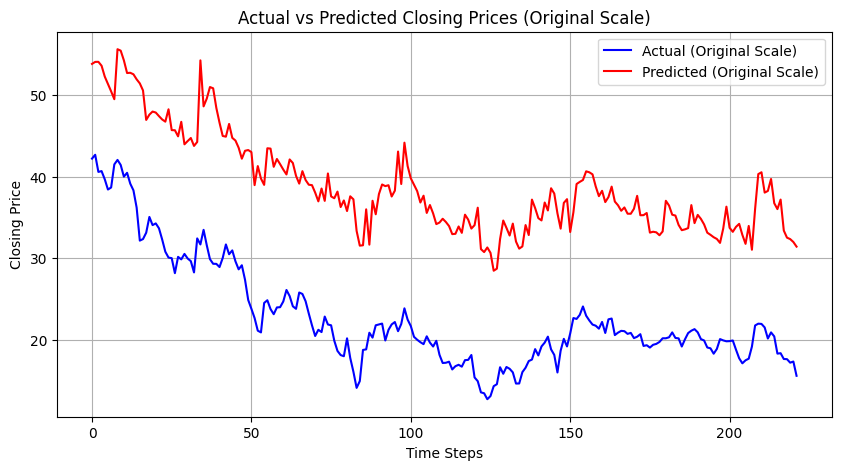

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
companies = data['Stock Name'].unique()
data = data.sort_values(by=['Stock Name', 'Date'])

#data.drop(columns=['Stock Name'], inplace=True)
data.drop(columns=['MA20'], inplace=True)
data.drop(columns=['logmomentum'], inplace=True)
data.drop(columns=['20SD'], inplace=True)
data.drop(columns=['MA7'], inplace=True)
data.drop(columns=['MACD'], inplace=True)
data.drop(columns=['upper_band'], inplace=True)
data.drop(columns=['lower_band'], inplace=True)
data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train (7 companies) and test (1 company)
train_data = data[data['Stock Name'] != companies[-1]]
test_data = data[data['Stock Name'] == companies[-1]]

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

## PLOT AAPL

Epoch 1/50


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32996\3576761055.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_32996\3576761055.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0803 - val_loss: 0.0020
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 6.2470e-05
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.2907e-04 - val_loss: 6.3829e-05
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 8.4461e-05
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 9.1149e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.6670e-04 - val_loss: 5.4141e-05
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0012 - val_loss: 1.3203e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 2.7563e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5402e-04 - val_loss: 9.4803e-05
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0899e-04 - val_loss: 6.7765e-05
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 7.4403e-05
Epoch 12/50
49/49 

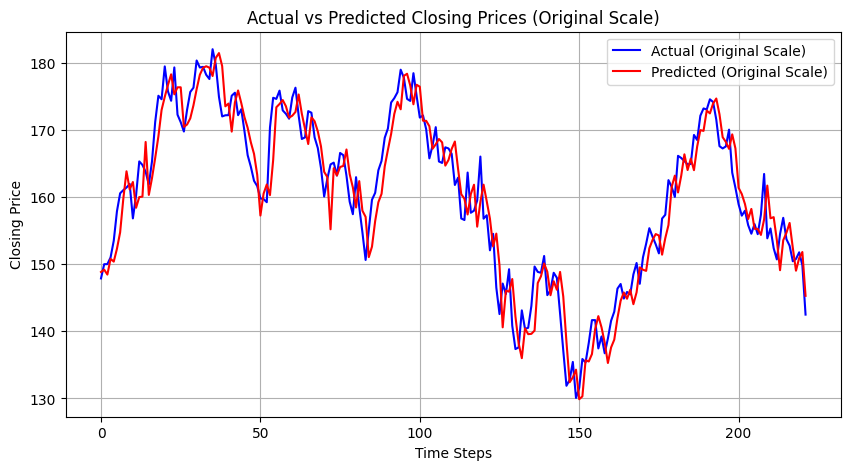

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
data = data.sort_values(by=['Stock Name', 'Date'])
companies = data['Stock Name'].unique()

#Let's drop indexes as are not needed in a time series model
data.drop(columns=['MA20'], inplace=True)
data.drop(columns=['logmomentum'], inplace=True)
data.drop(columns=['20SD'], inplace=True)
data.drop(columns=['MA7'], inplace=True)
data.drop(columns=['MACD'], inplace=True)
data.drop(columns=['upper_band'], inplace=True)
data.drop(columns=['lower_band'], inplace=True)
data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train and test datasets
test_data = data.iloc[:252]  # First 252 rows for testing
train_data = data.iloc[252:]  # Remaining rows for training

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 50
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
stock_names = data['Stock Name'].unique()
print(stock_names)


['AAPL' 'AMD' 'AMZN' 'MSFT' 'NIO' 'PG' 'TSLA' 'TSM']


## PLOT AMAZON

Epoch 1/50


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7916\1300866977.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="ffill", inplace=True)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7916\1300866977.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0039 - val_loss: 3.4122e-04
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.1069e-04 - val_loss: 1.5088e-04
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0014 - val_loss: 5.5829e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6730e-04 - val_loss: 1.5942e-04
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012 - val_loss: 5.8285e-04
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.3708e-04 - val_loss: 4.2201e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015 - val_loss: 4.4363e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.1239e-04 - val_loss: 9.8047e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.8758e-04 - val_loss: 1.0549e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.6668e-04 - val_loss: 3.1884e-04
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.5225e-04 - val_loss: 3.4813e-04
Ep

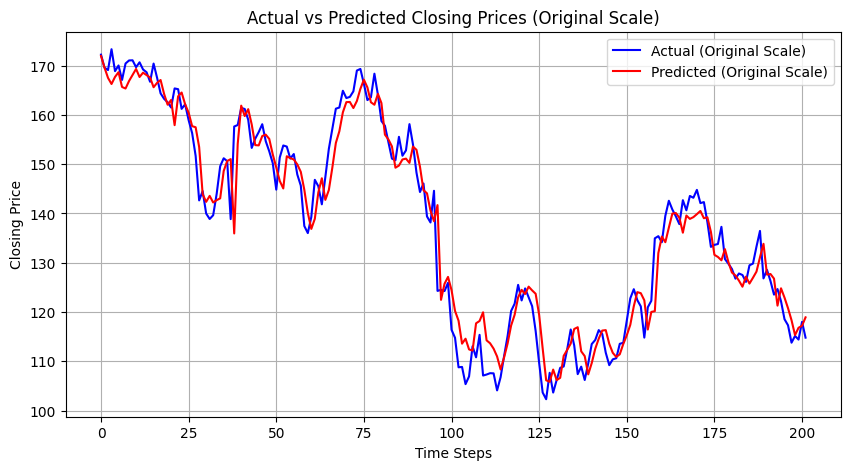

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
data = data.sort_values(by=['Stock Name', 'Date'])
companies = data['Stock Name'].unique()

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train and test datasets
block_size = 252
test_start = block_size * 2  # Third block starts at 2 * block_size
test_end = block_size * 3    # Third block ends at 3 * block_size

test_data = data.iloc[test_start:test_end]  # Third block of 252 rows for testing
train_data = pd.concat([data.iloc[:test_start], data.iloc[test_end:]])  # All rows except the third block for training

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 50  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model, this a simple time series regression
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 50
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


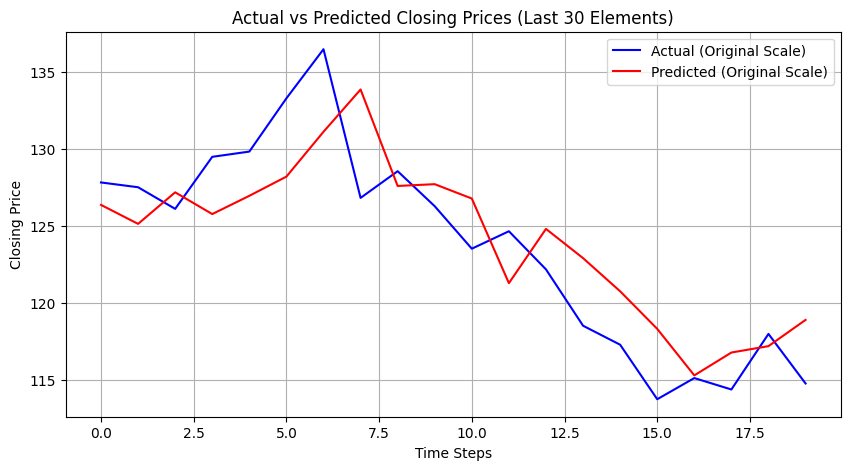

In [ ]:
# Plot predictions vs true values (last 30 elements only)
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[-20:], label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled[-20:], label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Last 30 Elements)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


## GAN

In [ ]:
!python -m pip install nltk


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!python -m pip install statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 98.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
#from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

# Ensure GPU is being used
def check_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("No GPU found. Using CPU instead.")
check_gpu()

stock_name = 'AMZN'
all_tweets = pd.read_csv('final_dataset_indexes.csv')
print(all_tweets.shape)
all_tweets.head()

ModuleNotFoundError: No module named 'statsmodels'

In [2]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(252, 16)


,Date,Open,High,Low,Close,Volume,Stock Name,Z_Score_Normalized,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
756,2021-09-30,165.800003,166.392502,163.699493,164.251999,56848000,AMZN,-0.466236,NaN,NaN,-1.548004,NaN,NaN,NaN,164.251999,5.095295
757,2021-10-01,164.450500,165.458496,162.796997,164.162994,56712000,AMZN,-0.466236,NaN,NaN,-1.386602,NaN,NaN,NaN,164.185246,5.094750
758,2021-10-04,163.969498,163.999496,158.812500,159.488998,90462000,AMZN,-0.466236,NaN,NaN,-2.831623,NaN,NaN,NaN,160.933998,5.065685
759,2021-10-05,160.225006,163.036499,160.123001,161.050003,65384000,AMZN,-0.466236,NaN,NaN,-2.452739,NaN,NaN,NaN,161.012301,5.075486
760,2021-10-06,160.676498,163.216995,159.931000,163.100494,50660000,AMZN,-0.231191,NaN,NaN,-1.624581,NaN,NaN,NaN,162.410183,5.088216


In [3]:
# Drop rows with at least one NaN value
df_clean = df.dropna()

#df_clean.drop(columns=['Z_Score_Normalized'], inplace=True)

#df_clean.drop(columns=['Volume'], inplace=True)
df_clean.drop(columns=['MA20'], inplace=True)
df_clean.drop(columns=['logmomentum'], inplace=True)
df_clean.drop(columns=['20SD'], inplace=True)
#df_clean.drop(columns=['MA7'], inplace=True)
df_clean.drop(columns=['MACD'], inplace=True)
df_clean.drop(columns=['upper_band'], inplace=True)
df_clean.drop(columns=['lower_band'], inplace=True)
df_clean.drop(columns=['EMA'], inplace=True)

# Display the number of rows before and after cleaning
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after cleaning: {len(df_clean)}")


Original number of rows: 252
Number of rows after cleaning: 233


In [4]:
dataset = df_clean
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
dataset = dataset.drop(columns='Stock Name')

In [5]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [6]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [7]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (228, 5, 7)
y shape: (228, 1)
yc shape: (228, 5, 1)


In [8]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [9]:
# Build GRU-based generator
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(units=1024, return_sequences=True,
                            input_shape=(input_dim, feature_size), recurrent_dropout=0.5),
        tf.keras.layers.GRU(units=512, return_sequences=True, recurrent_dropout=0.5),
        tf.keras.layers.GRU(units=256, return_sequences=True, recurrent_dropout=0.5),
        tf.keras.layers.GRU(units=128, return_sequences=True, recurrent_dropout=0.5),
        tf.keras.layers.GRU(units=64, recurrent_dropout=0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(units=output_dim)
    ])
    return model

In [10]:
# Build discriminator model
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential([
        tf.keras.layers.Conv1D(8, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                               input_shape=(input_dim + 1, 1)),
        tf.keras.layers.Conv1D(16, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(64, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(128, kernel_size=1, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(220, activation=tf.keras.layers.LeakyReLU()),
        tf.keras.layers.Dense(220, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return cnn_net


In [11]:
# Define loss functions
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_f(tf.ones_like(fake_output), fake_output)

In [12]:
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [13]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price)

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [14]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(12, 6))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [15]:
learning_rate = 5e-4
epochs = 500
output_dim = 1

g_optimizer = tf.keras.optimizers.Adam(learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

 10%|█         | 50/500 [00:43<05:56,  1.26it/s]

epoch 50 discriminator_loss 0.9917092 generator_loss 1.3007189


 20%|██        | 100/500 [01:22<05:15,  1.27it/s]

epoch 100 discriminator_loss 0.9191146 generator_loss 2.3169239


 30%|███       | 150/500 [02:02<04:36,  1.27it/s]

epoch 150 discriminator_loss 0.9249802 generator_loss 2.4173398


 40%|████      | 200/500 [02:41<03:55,  1.27it/s]

epoch 200 discriminator_loss 2.5717578 generator_loss 1.5324647


 50%|█████     | 250/500 [03:20<03:15,  1.28it/s]

epoch 250 discriminator_loss 1.5292845 generator_loss 0.60682815


 60%|██████    | 300/500 [03:59<02:39,  1.26it/s]

epoch 300 discriminator_loss 1.3322873 generator_loss 0.67551744


 70%|███████   | 350/500 [04:37<02:00,  1.24it/s]

epoch 350 discriminator_loss 1.3435831 generator_loss 0.72761476


 80%|████████  | 400/500 [05:16<01:20,  1.25it/s]

epoch 400 discriminator_loss 1.3256778 generator_loss 0.7713834


 90%|█████████ | 450/500 [05:55<00:41,  1.20it/s]

epoch 450 discriminator_loss 1.3206413 generator_loss 0.8220658


100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


epoch 500 discriminator_loss 1.2886517 generator_loss 0.8648042


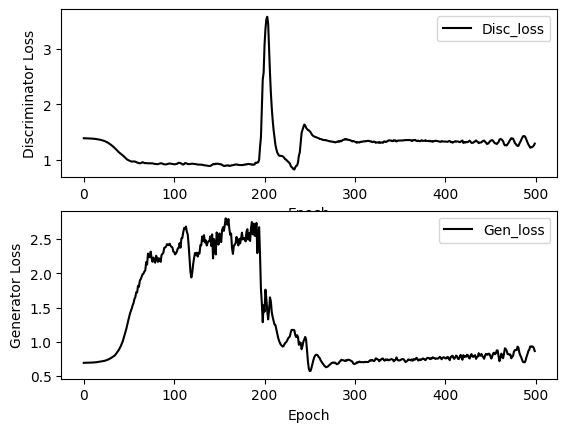

In [16]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [17]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

Test RMSE:  5.8821905302883115


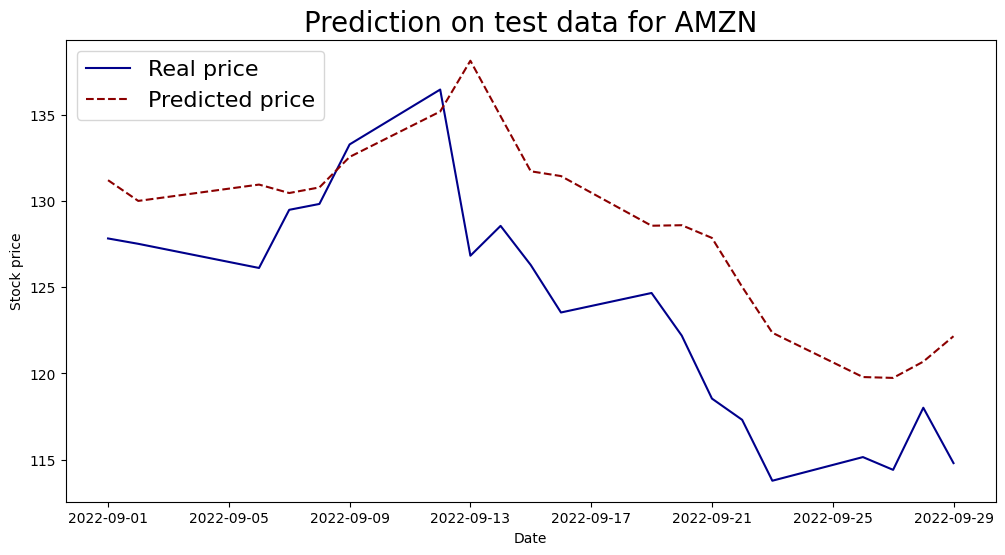

In [18]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
​
# Ensure GPU is being used
def check_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("No GPU found. Using CPU instead.")
​
check_gpu()
​
# Load and preprocess data
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)
data = data.sort_values(by=['Stock Name', 'Date'])
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)
​
# Scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
​
# Parameters
sequence_length = 30
input_dim = len(numeric_columns)  # Number of features
latent_dim = 100  # Dimensionality of the random noise for generator
​
# Split data
train_data = data.iloc[:-252]  # Train on all except the last 252 rows
test_data = data.iloc[-252:]  # Last 252 rows for testing
​
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length):
        sequences.append(df.iloc[i:i+sequence_length].values)
    return np.array(sequences)
​
# Prepare training and testing sequences
train_sequences = create_sequences(train_data[numeric_columns], sequence_length=sequence_length)
test_sequences = create_sequences(test_data[numeric_columns], sequence_length=sequence_length)
​
def create_targets(df, sequence_length, target_column):
    return df[target_column].values[sequence_length:]
​
target_column = 'Close'
test_targets = create_targets(test_data, sequence_length, target_column)
​
# Build Generator
def build_generator(sequence_length, input_dim, latent_dim):
    generator = Sequential([
        GRU(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, latent_dim)),
        GRU(128, activation='tanh', return_sequences=True),
        GRU(64, activation='tanh', return_sequences=True),
        GRU(64, activation='tanh', return_sequences=True),
        GRU(input_dim, activation='tanh', return_sequences=True)
    ])
    return generator
​
# Build Discriminator
def build_discriminator(sequence_length, input_dim):
    discriminator = Sequential([
        Flatten(input_shape=(sequence_length, input_dim)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Probability output
    ])
    return discriminator
​
# Initialize generator and discriminator
generator = build_generator(sequence_length, input_dim, latent_dim)
discriminator = build_discriminator(sequence_length, input_dim)
​
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
​
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(sequence_length, latent_dim))
    generated_sequence = generator(gan_input)
    gan_output = discriminator(generated_sequence)
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return gan
​
gan = build_gan(generator, discriminator)
​
# Training loop
batch_size = 64
epochs = 50
steps_per_epoch = len(train_sequences) // batch_size
​
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Train discriminator
        noise = np.random.normal(0, 1, size=(batch_size, sequence_length, latent_dim))
        fake_sequences = generator.predict(noise)
        real_sequences = train_sequences[np.random.randint(0, train_sequences.shape[0], batch_size)]
​
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
​
        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
​
        # Train generator
        noise = np.random.normal(0, 1, size=(batch_size, sequence_length, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
​
    print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")
​
# Generate synthetic sequences for evaluation
noise = np.random.normal(0, 1, size=(test_sequences.shape[0], sequence_length, latent_dim))
predicted_sequences = generator.predict(noise)
​
# Extract the 'Close' column index
close_index = numeric_columns.get_loc(target_column)
​
# Inverse scaling for real values
test_targets_rescaled = scaler.inverse_transform(test_data[numeric_columns])[:, close_index]
​
# Inverse scaling for predicted values
padded_predictions = np.pad(
    predicted_sequences[:, -1, :],  # Use the last step of each sequence
    ((0, 0), (0, len(numeric_columns) - predicted_sequences.shape[2])),  # Pad columns
    mode='constant',
    constant_values=0
)
predicted_values_rescaled = scaler.inverse_transform(padded_predictions)[:, close_index]
​
# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_targets_rescaled, label='Real', color='blue')
plt.plot(predicted_values_rescaled, label='Predicted', color='red')
plt.title('Real vs Predicted Values (Last Stock)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()